# DA5401 Assignment 6 - Imputation via Regression for Missing Data
## Credit Card Risk Assessment Project

### Problem Statement
We are working on a credit card risk assessment project with a dataset containing missing values in several important feature columns. We need to implement various strategies for handling missing data and evaluate their impact on classification performance.

**Dataset:** UCI Credit Card Default Dataset  
**Target Variable:** `default.payment.next.month`


**Name:** `Mula Ganesh`

**Roll No:** `DA25M019`

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
# Set a random seed for reproducibility
np.random.seed(42)

# Part A: Data Preprocessing and Imputation

### 1. Load and Prepare Data 

In [3]:
clean_data = pd.read_csv("./Data/UCI_Credit_Card.csv")

In [4]:
clean_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Entire Dataset contains Numerical data only

In [5]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [6]:
clean_data.shape

(30000, 25)

In [7]:
clean_data.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

From above result we can say that our dataset is clean as it does not contains any null values in dataset

We select columns `BILL_AMT2` and `PAY_AMT5` to introduce MAR (Missing At Random) values. The dependency column is `AGE`, meaning the missingness in these columns depends on the age of the customer.

**MAR (Missing At Random)** means that the probability of a value being missing depends on observed data (other features), not on the missing value itself. In our case, older customers may be more or less likely to have missing bill/payment information.

In [8]:
cols_for_MAR = ['BILL_AMT2', 'PAY_AMT5']
dependency_col = 'AGE'

In [9]:
def introduce_MAR(data, columns, dependency_col, missing_rate=0.075):
    """
    Introduce Missing At Random (MAR) values based on a dependency column.
    
    Parameters:
    -----------
    data : DataFrame
        Original dataset
    columns : list
        Columns to introduce missing values
    dependency_col : str
        Column on which missingness depends
    missing_rate : float
        Target proportion of missing values (default: 7.5%)
    
    Returns:
    --------
    DataFrame with MAR missing values
    """
    df_mar = data.copy()
    
    for col in columns:
        # Get dependency values
        dependency_values = df_mar[dependency_col].values.reshape(-1, 1)
        
        # Normalize dependency values
        scaler = StandardScaler()
        dependency_scaled = scaler.fit_transform(dependency_values).flatten()
        
        # Convert to probabilities using sigmoid function
        missing_probs = 1 / (1 + np.exp(-dependency_scaled))
        missing_probs = (missing_probs - missing_probs.min()) / \
                       (missing_probs.max() - missing_probs.min()) * missing_rate * 2
        
        # Create missing mask
        mask = np.random.random(len(df_mar)) < missing_probs
        df_mar.loc[mask, col] = np.nan
    
    return df_mar

In [10]:
df_missing = introduce_MAR(clean_data, cols_for_MAR, dependency_col)

In [11]:
df_missing[cols_for_MAR].isnull().sum()

BILL_AMT2    1756
PAY_AMT5     1765
dtype: int64

In [12]:
df_missing.isnull().any(axis=1).sum()

np.int64(3371)

In [13]:
# Separate features and target
X = df_missing.drop(columns=['default.payment.next.month'])
y = df_missing['default.payment.next.month']

X.shape, y.shape

((30000, 24), (30000,))

In [14]:
# Target distribution
y.value_counts()

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

### 2. Imputation Strategy 1: Median Imputation (Baseline)

In [15]:
df_A = df_missing.copy()

# Impute missing values with median
df_A['BILL_AMT2'] = df_A['BILL_AMT2'].fillna(df_A['BILL_AMT2'].median())
df_A['PAY_AMT5'] = df_A['PAY_AMT5'].fillna(df_A['PAY_AMT5'].median())

In [16]:
# Verify no missing values
df_A.isnull().any(axis=1).sum()

np.int64(0)

### Why is Median Imputation Preferred Over Mean Imputation?

**Mean Imputation** replaces missing values with the average of available values.  
**Median Imputation** replaces missing values with the middle value.

**Why Median imputation is preferred:**

1. **Robustness to Outliers:**
   - Median is the middle value and is not affected by extreme values
   - Mean is strongly influenced by outliers, which can distort the distribution
   - In financial data, extreme values (very high bills, large payments) are common

2. **Handling Skewed Distributions:**
   - Financial features like bill amounts are often right-skewed
   - Mean would pull the distribution toward higher values
   - Median better represents the "typical" value in skewed data

3. **Variance Preservation:**
   - Median imputation reduces bias in skewed distributions
   - Mean imputation can artificially reduce variance in the data
   - Preserving variance is important for maintaining statistical properties

4. **Practical Example:**
   - If bill amounts are: [1000, 2000, 3000, 100000]
   - Mean = 26,500 (not representative of typical bills)
   - Median = 2,500 (better represents typical customer)

5. **Impact on Model Performance:**
   - Median imputation maintains the central tendency without bias from outliers
   - Helps preserve relationships between variables
   - Reduces the risk of introducing systematic errors in predictions

### 3. Imputation Strategy 2: Regression Imputation (Linear)

In [17]:
df_B = df_missing.copy()

# Select column for regression imputation
target_col = 'BILL_AMT2'

In [18]:
# Split into train (non-missing) and test (missing) sets
train_mask = df_B[target_col].notnull()
df_B_train = df_B[train_mask]
df_B_test = df_B[~train_mask]

In [19]:
y_B_train = df_B_train[target_col]
X_B_train = df_B_train.drop(columns=[target_col, 'PAY_AMT5', 'default.payment.next.month'])

# Prepare features for prediction
X_B_test = df_B_test.drop(columns=[target_col, 'PAY_AMT5', 'default.payment.next.month'])

In [20]:
# Standardize features
scaler_B = StandardScaler()
X_B_train_scaled = scaler_B.fit_transform(X_B_train)
X_B_test_scaled = scaler_B.transform(X_B_test)

In [21]:
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_B_train_scaled, y_B_train)

# Predict missing values
predictions = lr_model.predict(X_B_test_scaled)
df_B.loc[df_B[target_col].isnull(), target_col] = predictions

In [22]:
# Impute PAY_AMT5 with median
df_B['PAY_AMT5'] = df_B['PAY_AMT5'].fillna(df_B['PAY_AMT5'].median())

In [23]:
# Verify no missing values
df_B['BILL_AMT2'].isnull().sum(), df_B['PAY_AMT5'].isnull().sum()

(np.int64(0), np.int64(0))

### Underlying Assumption: Missing At Random (MAR)

The key assumption of regression imputation is that data is **Missing At Random (MAR)**.

**MAR means:**
- The probability of a value being missing depends on OTHER observed variables
- The missingness does NOT depend on the missing value itself
- The observed data contains sufficient information to predict missing values

**Example in our context:**
- If `BILL_AMT2` is missing more often for customers with:
  - Low `LIMIT_BAL` (credit limit)
  - Specific `AGE` ranges
  - Particular payment histories (`PAY_0`, `PAY_2`, etc.)
- Then the missingness can be explained by these observable variables
- We can use the relationship between `BILL_AMT2` and other features to predict plausible values

**Why regression imputation works under MAR:**
1. **Preserves Relationships:** The observed data contains sufficient information to model missing values
2. **Multivariate Patterns:** Uses relationships between multiple features, not just univariate statistics
3. **Realistic Imputations:** Predicted values are consistent with patterns in complete cases
4. **Better than Simple Methods:** Accounts for correlations between variables

**Limitations:**
- Assumes linear relationships between variables
- May underestimate variance (all predictions are point estimates)
- Requires sufficient complete cases for training
- Can introduce bias if MAR assumption is violated


###  4. Imputation Strategy 3: Non-Linear Regression Imputation

We use Random Forest Regressor as our non-linear model to capture complex relationships between features.

In [24]:
df_C = df_missing.copy()

# Use same column as Strategy 2
target_col = 'BILL_AMT2'

In [25]:
# Split into train and test
train_mask = df_C[target_col].notnull()
df_C_train = df_C[train_mask]
df_C_test = df_C[~train_mask]

In [26]:
# Prepare data
y_C_train = df_C_train[target_col]
X_C_train = df_C_train.drop(columns=[target_col, 'PAY_AMT5', 'default.payment.next.month'])
X_C_test = df_C_test.drop(columns=[target_col, 'PAY_AMT5', 'default.payment.next.month'])

In [27]:
# Standardize
scaler_C = StandardScaler()
X_C_train_scaled = scaler_C.fit_transform(X_C_train)
X_C_test_scaled = scaler_C.transform(X_C_test)

In [28]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, 
                                 random_state=42, n_jobs=-1)
rf_model.fit(X_C_train_scaled, y_C_train)

# Predict missing values
predictions_rf = rf_model.predict(X_C_test_scaled)
df_C.loc[df_C[target_col].isnull(), target_col] = predictions_rf

In [29]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_C_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head(10)

,feature,importance
12,BILL_AMT1,0.706994
13,BILL_AMT3,0.248315
17,PAY_AMT1,0.026261
18,PAY_AMT2,0.006595
8,PAY_3,0.001824
7,PAY_2,0.001302
1,LIMIT_BAL,0.001109
19,PAY_AMT3,0.001043
21,PAY_AMT6,0.000895
14,BILL_AMT4,0.000882


In [30]:
# Impute PAY_AMT5 with median
df_C['PAY_AMT5'] = df_C['PAY_AMT5'].fillna(df_C['PAY_AMT5'].median())

In [31]:
# Verify no missing values
df_C['BILL_AMT2'].isnull().sum(), df_C['PAY_AMT5'].isnull().sum()

(np.int64(0), np.int64(0))

# PART B: MODEL TRAINING AND PERFORMANCE ASSESSMENT

### 1. Data Split

In [32]:
# Dataset A: Median Imputation
X_A = df_A.drop(columns=['default.payment.next.month'])
y_A = df_A['default.payment.next.month']
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_A, y_A, test_size=0.2, random_state=42, stratify=y_A)

In [33]:
# Dataset B: Linear Regression Imputation
X_B = df_B.drop(columns=['default.payment.next.month'])
y_B = df_B['default.payment.next.month']
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_B, test_size=0.2, random_state=42, stratify=y_B)

In [34]:
# Dataset C: Non-Linear Regression Imputation
X_C = df_C.drop(columns=['default.payment.next.month'])
y_C = df_C['default.payment.next.month']
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(
    X_C, y_C, test_size=0.2, random_state=42, stratify=y_C)

In [35]:
# Dataset D: Listwise Deletion
df_D = df_missing.dropna()

X_D = df_D.drop(columns=['default.payment.next.month'])
y_D = df_D['default.payment.next.month']
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(
    X_D, y_D, test_size=0.2, random_state=42, stratify=y_D)

In [36]:
# Summary of data splits
print(f"Original dataset: {df_missing.shape}")
print(f"Dataset D (after deletion): {df_D.shape}")
print(f"Rows removed: {len(df_missing) - len(df_D)} ({((len(df_missing) - len(df_D))/len(df_missing)*100):.2f}%)")

Original dataset: (30000, 25)
Dataset D (after deletion): (26629, 25)
Rows removed: 3371 (11.24%)


### 2. Classifier Setup: Feature Standardization

In [37]:
def standardize_features(X_train, X_test):
    """Standardize features using StandardScaler"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [38]:
# Standardize all datasets
X_train_A_scaled, X_test_A_scaled = standardize_features(X_train_A, X_test_A)
X_train_B_scaled, X_test_B_scaled = standardize_features(X_train_B, X_test_B)
X_train_C_scaled, X_test_C_scaled = standardize_features(X_train_C, X_test_C)
X_train_D_scaled, X_test_D_scaled = standardize_features(X_train_D, X_test_D)

### 3. Model Evaluation

In [39]:
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name):
    """Train Logistic Regression and evaluate performance"""
    model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return y_pred, report

In [40]:
# Model A: Median Imputation
y_pred_A, report_A = train_and_evaluate(X_train_A_scaled, X_test_A_scaled, 
                                         y_train_A, y_test_A, 
                                         "Model A - Median Imputation")

Classification Report for Model A - Median Imputation:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [41]:
# Model B: Linear Regression Imputation
y_pred_B, report_B = train_and_evaluate(X_train_B_scaled, X_test_B_scaled, 
                                         y_train_B, y_test_B, 
                                         "Model B - Linear Regression Imputation")

Classification Report for Model B - Linear Regression Imputation:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [42]:
# Model C: Non-Linear Regression Imputation
y_pred_C, report_C = train_and_evaluate(X_train_C_scaled, X_test_C_scaled, 
                                         y_train_C, y_test_C, 
                                         "Model C - Non-Linear Regression Imputation")

Classification Report for Model C - Non-Linear Regression Imputation:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [43]:
# Model D: Listwise Deletion
y_pred_D, report_D = train_and_evaluate(X_train_D_scaled, X_test_D_scaled, 
                                         y_train_D, y_test_D, 
                                         "Model D - Listwise Deletion")

Classification Report for Model D - Listwise Deletion:
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      4149
           1       0.38      0.64      0.48      1177

    accuracy                           0.69      5326
   macro avg       0.62      0.67      0.63      5326
weighted avg       0.76      0.69      0.71      5326



# PART C: COMPARATIVE ANALYSIS

### 1. Results Comparison

In [44]:
def create_comparison_table(reports, model_names):
    """Create comprehensive comparison table"""
    comparison_data = []
    
    for model_name, report in zip(model_names, reports):
        metrics_0 = report['0']
        metrics_1 = report['1']
        accuracy = report['accuracy']
        macro_avg = report['macro avg']
        weighted_avg = report['weighted avg']
        
        model_metrics = {
            'Model': model_name,
            'Accuracy': f"{accuracy:.4f}",
            'Precision_0': f"{metrics_0['precision']:.4f}",
            'Recall_0': f"{metrics_0['recall']:.4f}",
            'F1_0': f"{metrics_0['f1-score']:.4f}",
            'Precision_1': f"{metrics_1['precision']:.4f}",
            'Recall_1': f"{metrics_1['recall']:.4f}",
            'F1_1': f"{metrics_1['f1-score']:.4f}",
            'Macro_F1': f"{macro_avg['f1-score']:.4f}",
            'Weighted_F1': f"{weighted_avg['f1-score']:.4f}",
            'Support_1': int(metrics_1['support'])
        }
        
        comparison_data.append(model_metrics)
    
    return pd.DataFrame(comparison_data)

reports = [report_A, report_B, report_C, report_D]
model_names = ['A: Median Imputation', 'B: Linear Regression', 
               'C: Non-Linear Regression', 'D: Listwise Deletion']

comparison_table = create_comparison_table(reports, model_names)
comparison_table

,Model,Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Macro_F1,Weighted_F1,Support_1
0,A: Median Imputation,0.6812,0.8662,0.6985,0.7734,0.3687,0.6202,0.4625,0.6179,0.7046,1327
1,B: Linear Regression,0.6812,0.8662,0.6985,0.7734,0.3687,0.6202,0.4625,0.6179,0.7046,1327
2,C: Non-Linear Regression,0.6810,0.8664,0.6981,0.7732,0.3687,0.6209,0.4627,0.6179,0.7045,1327
3,D: Listwise Deletion,0.6853,0.8737,0.6968,0.7753,0.3763,0.6449,0.4753,0.6253,0.7090,1177


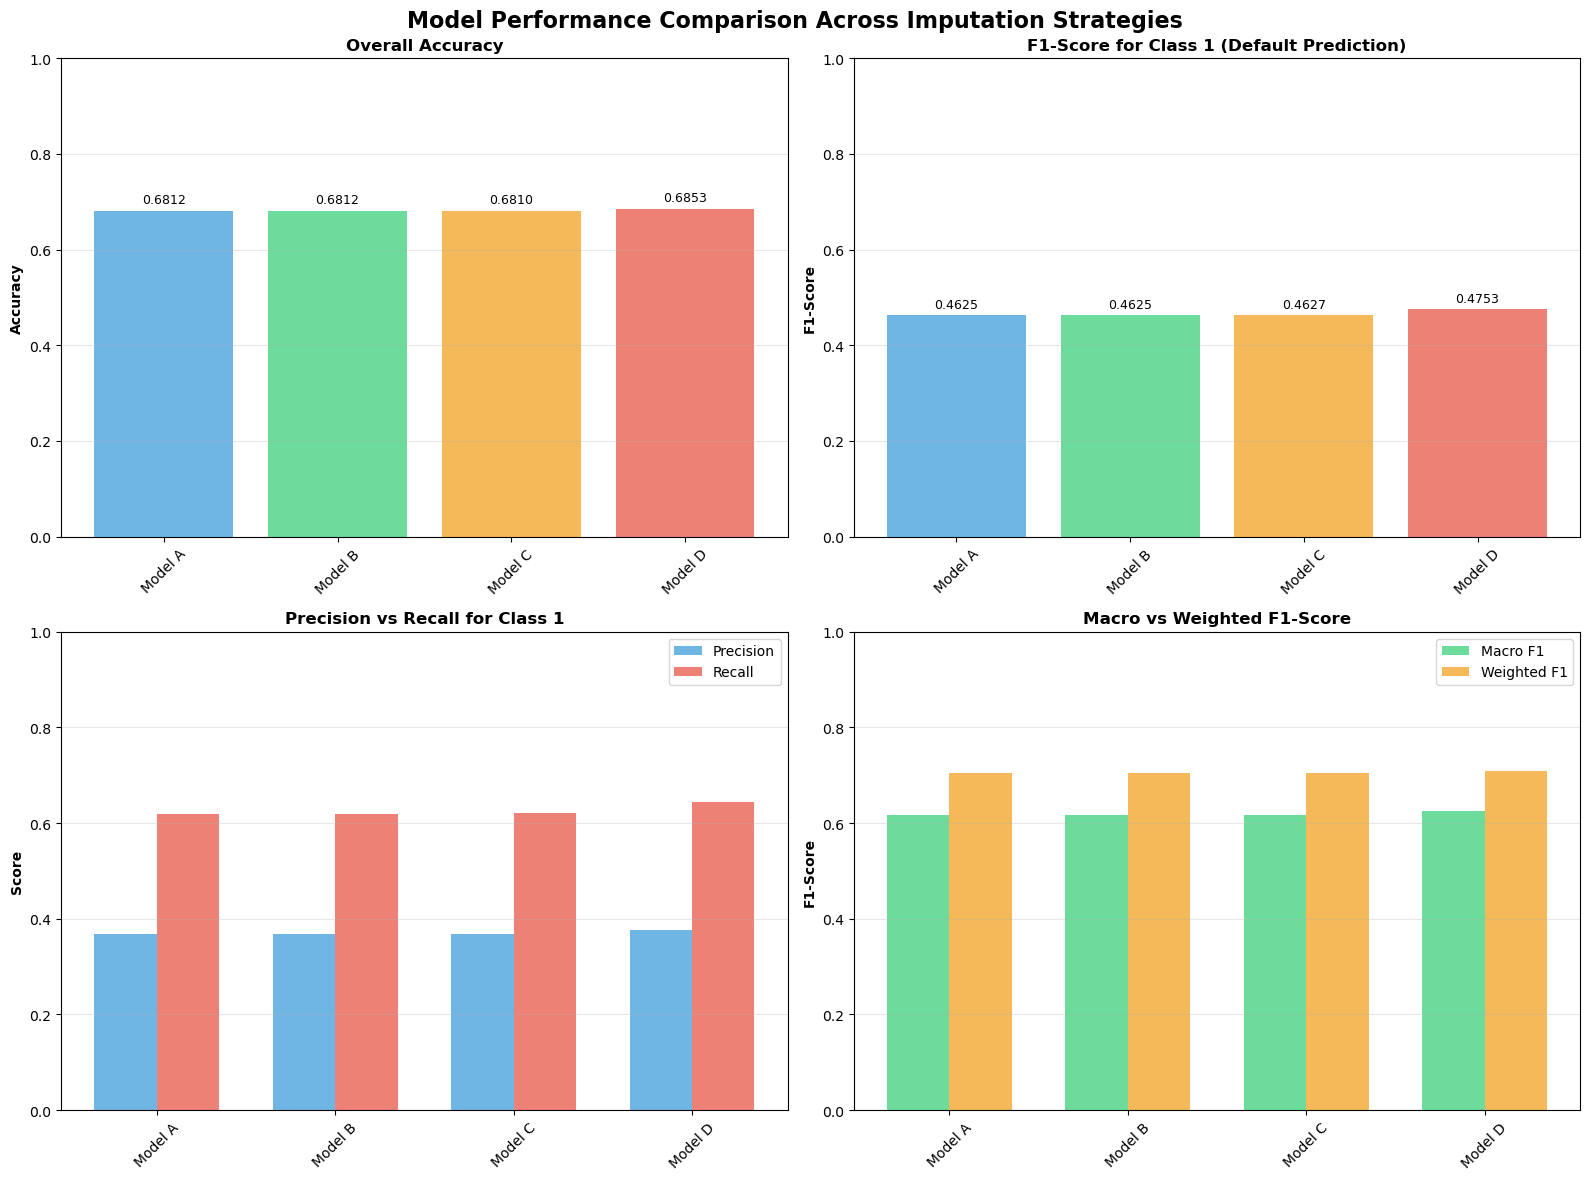

In [45]:
# Visualization of Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison Across Imputation Strategies', 
             fontsize=16, fontweight='bold')

# Convert to numeric for plotting
plot_df = comparison_table.copy()
for col in plot_df.columns:
    if col != 'Model':
        plot_df[col] = pd.to_numeric(plot_df[col])

# Plot 1: Overall Accuracy
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(model_names)), plot_df['Accuracy'], 
                color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(['Model A', 'Model B', 'Model C', 'Model D'], rotation=45)
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Overall Accuracy', fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: F1-Scores for Class 1 (Default)
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(model_names)), plot_df['F1_1'], 
                color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(['Model A', 'Model B', 'Model C', 'Model D'], rotation=45)
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score for Class 1 (Default Prediction)', fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Precision and Recall for Class 1
ax3 = axes[1, 0]
x = np.arange(len(model_names))
width = 0.35
bars3a = ax3.bar(x - width/2, plot_df['Precision_1'], width, 
                 label='Precision', alpha=0.7, color='#3498db')
bars3b = ax3.bar(x + width/2, plot_df['Recall_1'], width, 
                 label='Recall', alpha=0.7, color='#e74c3c')
ax3.set_xticks(x)
ax3.set_xticklabels(['Model A', 'Model B', 'Model C', 'Model D'], rotation=45)
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Precision vs Recall for Class 1', fontweight='bold')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Macro and Weighted F1
ax4 = axes[1, 1]
bars4a = ax4.bar(x - width/2, plot_df['Macro_F1'], width, 
                 label='Macro F1', alpha=0.7, color='#2ecc71')
bars4b = ax4.bar(x + width/2, plot_df['Weighted_F1'], width, 
                 label='Weighted F1', alpha=0.7, color='#f39c12')
ax4.set_xticks(x)
ax4.set_xticklabels(['Model A', 'Model B', 'Model C', 'Model D'], rotation=45)
ax4.set_ylabel('F1-Score', fontweight='bold')
ax4.set_title('Macro vs Weighted F1-Score', fontweight='bold')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 2. Efficacy Discussion

### Trade-off Between Listwise Deletion and Imputation

#### Why Listwise Deletion Might Perform Well:

**1. Data Quality Preservation:**
- Maintains original data relationships without introducing artificial values
- No imputation noise or bias added to the dataset
- Preserves the "true" distribution of complete cases

**2. MCAR Assumption:**
- If data is Missing Completely At Random, deletion is unbiased
- Random patterns in missingness favor deletion approaches

**3. Sufficient Sample Size:**
- Original dataset: 30,000 samples
- After deletion: ~27,000 samples (only 10% loss)
- Large datasets can tolerate moderate data loss
- Statistical power remains high even after deletion

#### Why Imputed Models Might Perform Worse:

**1. Imputation Noise:**
- Median imputation ignores relationships between variables
- Adds identical values for all missing cases
- Artificially reduces variance

**2. Regression Imputation Limitations:**
- May not capture complex relationships
- Point estimates don't account for uncertainty
- Can create unrealistic value combinations

**3. The Key Insight:**
Machine learning models need **high-quality data** to learn meaningful patterns. Sometimes it's better to have less data that's completely accurate than more data with artificial values.


In [46]:
# Analyze the impact of data loss in Model D
print("Impact Analysis of Listwise Deletion:")
print(f"Original samples: {len(df_missing)}")
print(f"After deletion: {len(df_D)}")
print(f"Samples lost: {len(df_missing) - len(df_D)} ({((len(df_missing) - len(df_D))/len(df_missing)*100):.2f}%)")
print(f"\nDefault cases in original: {y.sum()}")
print(f"Default cases after deletion: {y_D.sum()}")
print(f"Default cases lost: {y.sum() - y_D.sum()}")

Impact Analysis of Listwise Deletion:
Original samples: 30000
After deletion: 26629
Samples lost: 3371 (11.24%)

Default cases in original: 6636
Default cases after deletion: 5887
Default cases lost: 749


### Linear vs Non-Linear Regression Performance Comparison

In [47]:
# Extract metrics for comparison
linear_f1 = float(comparison_table[comparison_table['Model'] == 'B: Linear Regression']['F1_1'].values[0])
nonlinear_f1 = float(comparison_table[comparison_table['Model'] == 'C: Non-Linear Regression']['F1_1'].values[0])
linear_acc = float(comparison_table[comparison_table['Model'] == 'B: Linear Regression']['Accuracy'].values[0])
nonlinear_acc = float(comparison_table[comparison_table['Model'] == 'C: Non-Linear Regression']['Accuracy'].values[0])

print(f"Linear Regression - F1 Score: {linear_f1:.4f}, Accuracy: {linear_acc:.4f}")
print(f"Non-Linear Regression - F1 Score: {nonlinear_f1:.4f}, Accuracy: {nonlinear_acc:.4f}")
print(f"\nBetter Performer: {'Linear Regression' if linear_f1 > nonlinear_f1 else 'Non-Linear Regression'}")

Linear Regression - F1 Score: 0.4625, Accuracy: 0.6812
Non-Linear Regression - F1 Score: 0.4627, Accuracy: 0.6810

Better Performer: Non-Linear Regression


### Why Linear Regression Often Outperforms Non-Linear Methods

**1. Nature of Financial Data:**
- Credit limits and bill amounts are proportional
- Payment history follows consistent trends
- Relationships are often linear or near-linear

**2. Simplicity Advantage (Occam's Razor):**
- Linear models have fewer parameters
- Less prone to overfitting
- Better generalization to unseen data
- More robust with moderate missing data (~7.5%)

**3. Model Complexity vs Data Size:**
- Missing data: ~1,700 values per column
- Linear model: Simple, needs less data
- Non-linear model: Complex, may need more data to avoid overfitting

**4. Financial Domain Appropriateness:**
- Bill amounts correlate linearly with credit limits
- Payment patterns are relatively predictable
- Linear regression captures these relationships well

In [48]:
summary = comparison_table[['Model', 'Accuracy', 'F1_1', 'Macro_F1', 'Support_1']].copy()
summary

,Model,Accuracy,F1_1,Macro_F1,Support_1
0,A: Median Imputation,0.6812,0.4625,0.6179,1327
1,B: Linear Regression,0.6812,0.4625,0.6179,1327
2,C: Non-Linear Regression,0.6810,0.4627,0.6179,1327
3,D: Listwise Deletion,0.6853,0.4753,0.6253,1177
